In [1]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections as mc

from src.datasets import get_dataset
from src.modules import get_model, get_loss_fn, get_optimizer, CaptureLayer


In [2]:
class Engine:

    def build(self, config_path):
        with open(config_path) as f:
            self.config = self._mod_config(json.load(f))
        self.dataset = get_dataset(self.config["dataset"], "datasets")
        self.model = get_model(self.config["model"], self.dataset.input_shape, self.dataset.num_classes)
        self.loss_fn = get_loss_fn(self.config["fit"]["loss_fn"])
        self.mod_loss_fn = self._mod_loss_fn(self.loss_fn)
        self.optim = get_optimizer(self.config["fit"]["optimizer"], self.model.parameters())
        self.num_samples = self.config["fit"]["num_samples"]
        self.epoch = 0

    def _mod_config(self, config):
        return config

    def _mod_loss_fn(self, loss_fn):
        return loss_fn

    def load(self, checkpoint_path):
        state = torch.load(checkpoint_path, map_location="cpu")
        self.epoch = state["epoch"]
        self.model.set_epoch(self.epoch)
        self.model.load_state_dict(state["model"])
        self.optim.load_state_dict(state["optimizer"])

    def next(self):
        self.epoch += 1
        self.model.set_epoch(self.epoch)
        return self.epoch

    def train(self, label, device):
        self.model.train()
        progress = tqdm(self.dataset.train_loader, desc=label, leave=False)
        for step, (inputs, targets) in enumerate(progress):
            inputs = inputs.unsqueeze(0).expand(self.num_samples, *inputs.shape)
            targets = targets.unsqueeze(0).expand(self.num_samples, *targets.shape)
            self.optim.zero_grad()
            outputs = self.model(inputs)
            losses = self.mod_loss_fn(outputs, targets)
            losses.mean().backward()
            self.optim.step()
            yield step + 1

    def eval(self, label, device):
        frame = defaultdict(lambda: 0)
        self.model.train()
        progress = tqdm(self.dataset.test_loader, desc=label, leave=False)
        for inputs, targets in progress:
            inputs = inputs.unsqueeze(0).expand(self.num_samples, *inputs.shape)
            targets = targets.unsqueeze(0).expand(self.num_samples, *targets.shape)
            self.optim.zero_grad()
            outputs = self.model(inputs)
            losses = self.loss_fn(outputs, targets)
            losses.mean().backward()
            self._add_states(frame, len(self.dataset.test_loader))
        self._add_weights(frame)
        return dict(frame)

    def _add_weights(self, frame):
        for i, m in enumerate(self.model):
            if isinstance(m, nn.Linear):
                w, n = m.weight.detach(), self.config["model"]["hidden_dim"]
                if m.in_features == n: frame[f"{i}.weight.t1"] = w.T @ w

    def _add_states(self, frame, size):
        for i, m in enumerate(self.model):
            if isinstance(m, CaptureLayer):
                frame[f"{i}.state.m2"] += self._outer_mean(m.state.detach()) / size
                frame[f"{i}.grad.m2"] += self._outer_mean(m.state.grad * m.state.shape[0]) / size

    def _outer_mean(self, x):
        x = x.flatten(end_dim=-2)
        return x.T @ x / x.shape[0]

In [3]:
class Snapshot(Engine):

    def __init__(self, dir_path, label, sample, start_epoch, stop_epoch, num_steps, prefix="gradient"):
        self.start_epoch = start_epoch
        self.stop_epoch = stop_epoch
        self.num_steps = num_steps
        self.output_path = f"{dir_path}/{label}_{sample}/{prefix}-{start_epoch}-{stop_epoch}-{num_steps}.pt"
        self.config_path = f"{dir_path}/{label}_{sample}/config.json"
        self.checkpoint_path = f"{dir_path}/{label}_{sample}/checkpoint-{start_epoch}.pt"

    def __call__(self, device="cpu"):
        if os.path.exists(self.output_path):
            return torch.load(self.output_path)
        data = self._run(device)
        torch.save(data, self.output_path)
        return data

    def _run(self, device):

        self.build(self.config_path)
        if not self.checkpoint_path.endswith("-0.pt"):
            self.load(self.checkpoint_path)

        data = []
        label = f"{self.output_path}@{self.epoch}"
        data.append(self.eval(label, device))
        while self.next() <= self.stop_epoch:
            label = f"{self.output_path}@{self.epoch}"
            for step in self.train(label, device):
                if step % self.num_steps == 0:
                    data.append(self.eval(label, device))
        return data


class SwitchSnapshot(Snapshot):

    def __init__(self, dir_path, label, new_label, sample, epoch, num_epochs, num_steps):
        super().__init__(dir_path, label, sample, epoch, num_epochs, num_steps, f"gradient-{new_label}_{sample}")
        self.config_path = f"{dir_path}/{new_label}_{sample}/config.json"


class DiffSnapshot(Snapshot):

    def __init__(self, dir_path, label, sample, epoch, num_epochs, num_steps):
        super().__init__(dir_path, label, sample, epoch, num_epochs, num_steps, "gradient-diff")

    def _mod_loss_fn(self, loss_fn):
        return  lambda x, y: loss_fn(x, y).mean(0, keepdim=True) - loss_fn(x.mean(0, keepdim=True), y[:1])


class MeanSnapshot(Snapshot):

    def __init__(self, dir_path, label, sample, epoch, num_epochs, num_steps):
        super().__init__(dir_path, label, sample, epoch, num_epochs, num_steps, "gradient-mean")

    def _mod_loss_fn(self, loss_fn):
        return lambda x, y: loss_fn(x.mean(0, keepdim=True), y[:1])

In [30]:
def get_epoch_length(cfg):
    learning_rate = cfg["fit"]["optimizer"]["learning_rate"]
    batch_size = cfg["dataset"]["train"]["batch_size"]
    dataset = get_dataset(cfg["dataset"], "datasets")
    dataset_size = len(dataset.train_loader)
    return learning_rate * dataset_size / batch_size

def read_logs(dir_path, labels):
    df_list = []
    for label in labels:
        for sample in range(10):
            try:
                with open(f"{dir_path}/{label}_{sample}/config.json") as f:
                    cfg = json.load(f)
                df = pd.read_json(f"{dir_path}/{label}_{sample}/logs.json")
            except:
                continue
            df["label"] = label
            df["sample"] = sample
            df["epoch"] = df.index + 1
            df["length"] = df["epoch"] * get_epoch_length(cfg)
            df_list.append(df)
    return pd.concat(df_list)

def agg_logs(df, method):
    df = df.groupby(["label", "epoch"], sort=False).agg(method)
    df = df.reset_index().set_index("epoch").groupby("label", sort=False)
    return df

def gridplot(xlabels, ylabels, sharex=True, sharey=True, xsize=2, ysize=2, dpi=100):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
        sharex=sharex, sharey=sharey, dpi=dpi,
        figsize=(ncols*xsize, nrows*ysize))
    if nrows == 1: axes = [axes]
    if ncols == 1: axes = [[ax] for ax in axes]
    for j, xlabel in enumerate(xlabels):
        for i, ylabel in enumerate(ylabels):
            ax = axes[i][j]
            if j == 0 or not sharey: ax.set_ylabel(ylabel)
            if i == len(ylabels)-1 or not sharex: ax.set_xlabel(xlabel)
    return fig, axes

def plot_segments(ax, xs, ys, rx, ry, sat=10):
    ax.set_xlim(*rx)
    ax.set_ylim(*ry)
    ax.scatter(xs[0], ys[0], s=1, c="gray")
    for x0, x1, y0, y1 in zip(xs[:-1], xs[1:], ys[:-1], ys[1:]):
        u = (x1 - x0) / (rx[1] - rx[0])
        v = (y1 - y0) / (ry[1] - ry[0])
        r = (u.square() + v.square() + 1e-8).sqrt()
        n = (r*sat).tanh() / r
        c = yuv_color(0.5, u*n, v*n)
        lc = mc.LineCollection(torch.stack([
            torch.stack([x0, x1], -1), torch.stack([y0, y1], -1)
        ], -1), colors=[tuple(v) for v in c], linewidth=0.5)
        ax.add_collection(lc)

def yuv_color(y, u, v):
    r = y + (1.370705 * v)
    g = y - (0.698001 * v) - (0.337633 * u)
    b = y + (1.732446 * u)
    r = r.clamp(0, 1)
    g = g.clamp(0, 1)
    b = b.clamp(0, 1)
    return torch.stack([r, g, b], -1)

def get_weight(ckpt, i, flip=False):
    w = ckpt["model"][f"{i}.weight"]
    if flip:
        w = w.T
    return w.T @ w

def get_state(ckpt, i):
    s0 = ckpt["model"][f"{i}.test_agg.s0"]
    s2 = ckpt["model"][f"{i}.test_agg.s2"]
    return s2 / s0

In [34]:
def outer(x):
    return x.unsqueeze(-2) * x.unsqueeze(-1)

def norm(x):
    return x * outer(1 / x.diagonal().sqrt())

def diff2(x):
    d = x.diagonal()
    return d.unsqueeze(-2) + d.unsqueeze(-1) - x * 2

In [5]:
d = 100
kind = "off-diag"
if kind == "off-diag":
    n = 100
    i = torch.randint(d, size=(n,))
    j = torch.randint(d-1, size=(n,))
    j = j + (j >= i) # skip diagonal
elif kind == "diag":
    i = torch.arange(d)
    j = torch.arange(d)
elif kind == "row":
    i = 0
    j = torch.arange(d)
idx = (i, j)

In [66]:
act = "tanh"
#dir_path, labels = "outputs/lyr", [f"mean_{act}_l{i}" for i in ("", 1, 2, 3, 123)]
#dir_path, labels = "outputs/onn", [f"mean_weight_{act}_l{i}" for i in ("", 1, 2, 3, 123)]
#dir_path, labels = "outputs/dim", [f"mean_{act}_d{i}" for i in (100, 200, 300, 400)]
dir_path, labels = "outputs/std", [f"mean_{act}_s{v}" for v in (0.3, 0.5, 0.7, 1.0)]
#dir_path, labels = "outputs/test", [f"{s}_erf-t" for s in ("none", "mean",)]
layers = ["layer 1", "layer 2", "layer 3"]
epochs = [0, 10, 20, 30, 40, 50]
sample = 0

Files already downloaded and verified
Files already downloaded and verified


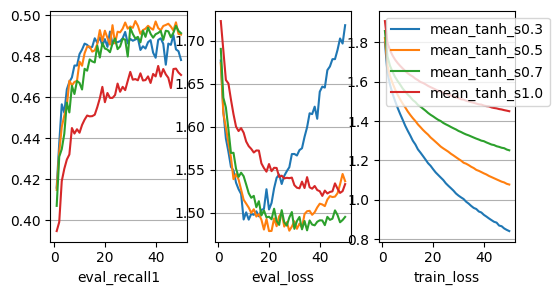

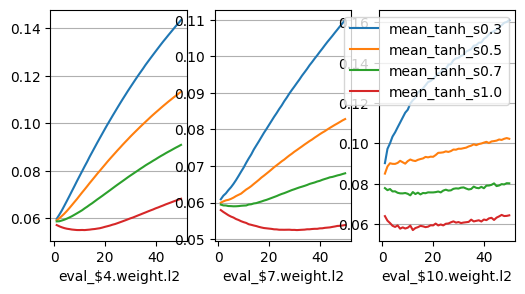

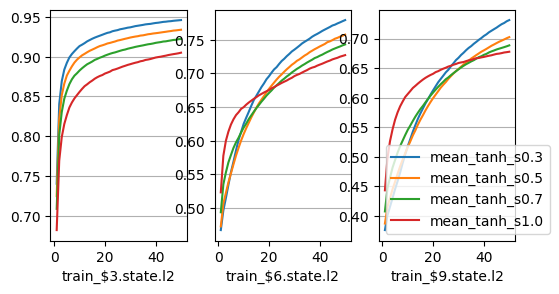

In [7]:
def plot_curve_xy(mdf, xmetrics, ymetrics):
    fig, axes = gridplot(xmetrics, [""], xsize=3, ysize=3, sharex=False, sharey=False)
    for i, (xmetric, ymetric) in enumerate(zip(xmetrics, ymetrics)):
        ax = axes[0][i]
        ax.set_ylabel(ymetric)
        ax.grid(axis="y")
        for (label, x), (_, y) in zip(mdf[xmetric], mdf[ymetric]):
            ax.plot(x, y, label=label)
    ax.legend()

def plot_curve_std(mdf, sdf, metrics):
    fig, axes = gridplot(metrics, [""], ysize=3, sharey=False)
    for i, metric in enumerate(metrics):
        ax = axes[0][i]
        ax.grid(axis="y")
        for (label, m), (_, s) in zip(mdf[metric], sdf[metric]):
            ax.plot(m, label=label)
            ax.fill_between(m.index, m-s, m+s, alpha=0.125)
    ax.legend()
    
weights = [f"eval_${i*3+4}.weight.l2" for i in range(3)]
states = [f"train_${i*3+3}.state.l2" for i in range(3)]
df = read_logs(dir_path, labels)
#scale = df["label"].str.slice(-3).astype(int)
#for weight in weights: df[weight] *= scale
mdf, sdf = agg_logs(df, "mean"), agg_logs(df, "std")
plot_curve_std(mdf, sdf, ["eval_recall1", "eval_loss", "train_loss"])
#plot_curve_xy(mdf, weights, states)
plot_curve_std(mdf, sdf, weights)
plot_curve_std(mdf, sdf, states)

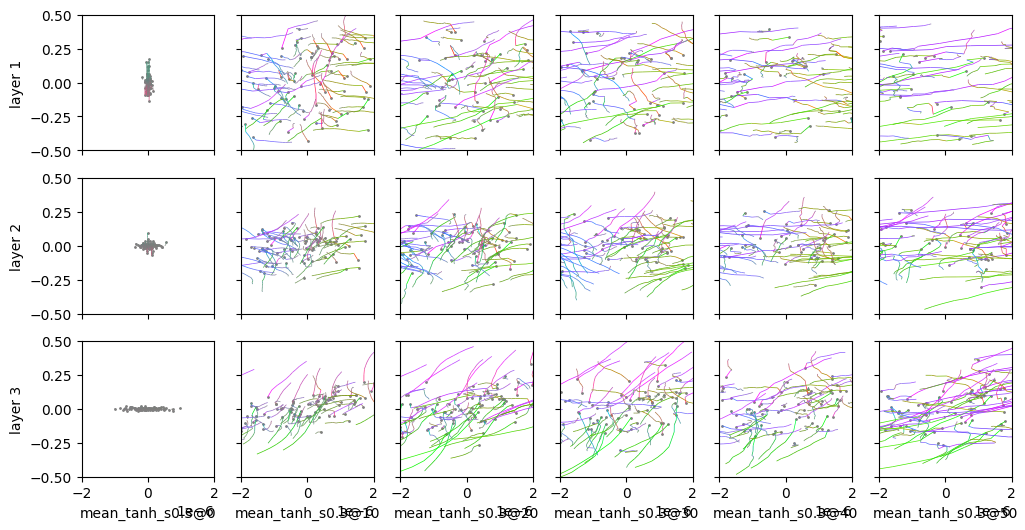

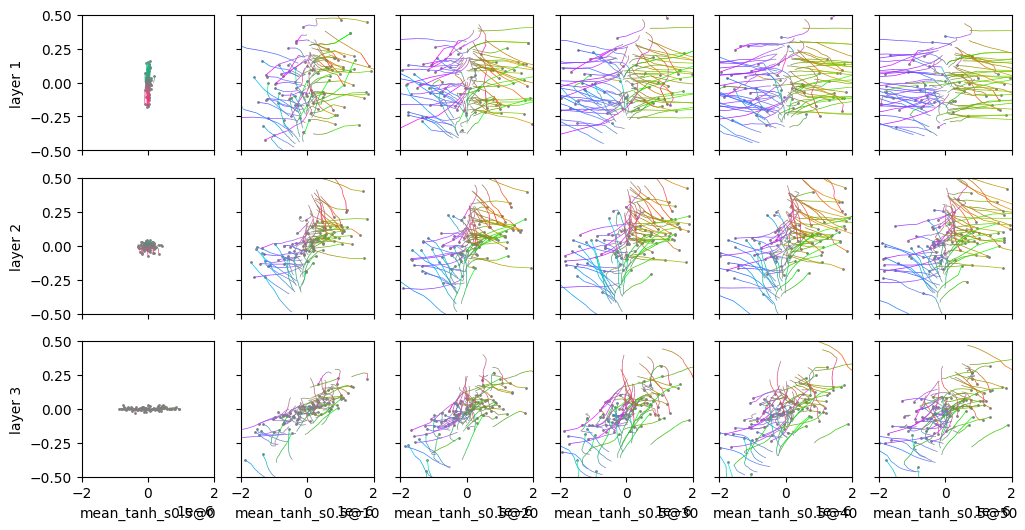

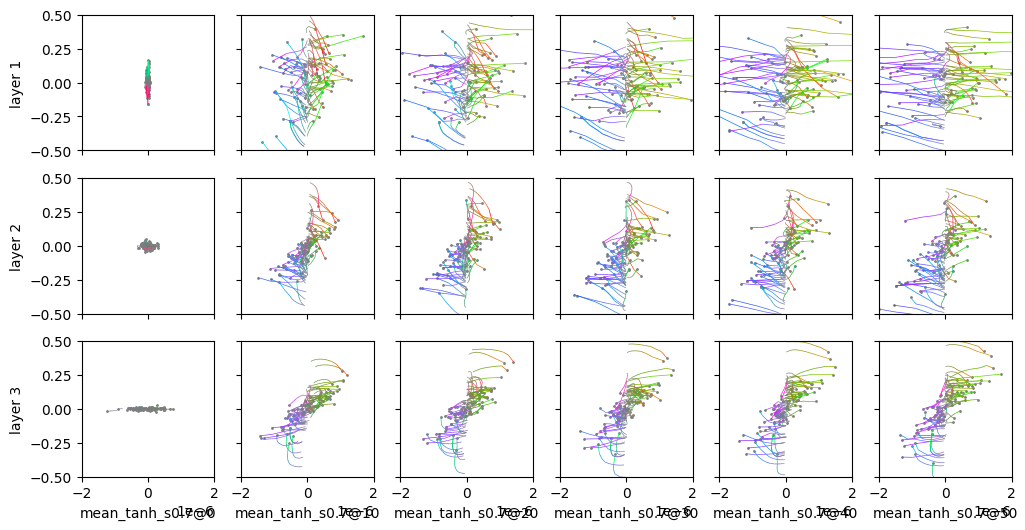

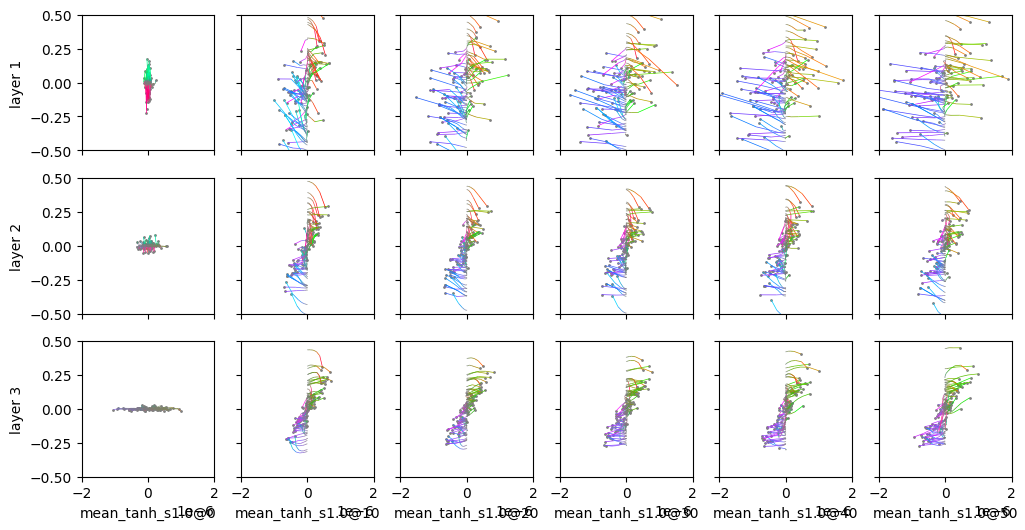

In [54]:
for label in labels:
    _, axes = gridplot([f"{label}@{i}" for i in epochs], layers)
    for j, epoch in enumerate(epochs):
        s = DiffSnapshot(dir_path, label, sample, epoch, epoch+1, 100)()
        #s = [{k: norm(v) for k, v in t.items()} for t in s]
        for i, layer in enumerate(layers):
            ax = axes[i][j]
            #kx, rx = f"{i*3+4}.weight.t1", (-.5, .5)
            kx, rx = f"{i*3+3}.grad.m2", (-2e-6, 2e-6)
            ky, ry = f"{i*3+3}.state.m2", (-.5, .5)
            #rx, ry = (-1, 1), (-1, 1)
            xs = [t[kx][idx] for t in s]
            ys = [t[ky][idx] for t in s]
            plot_segments(ax, xs, ys, rx, ry)

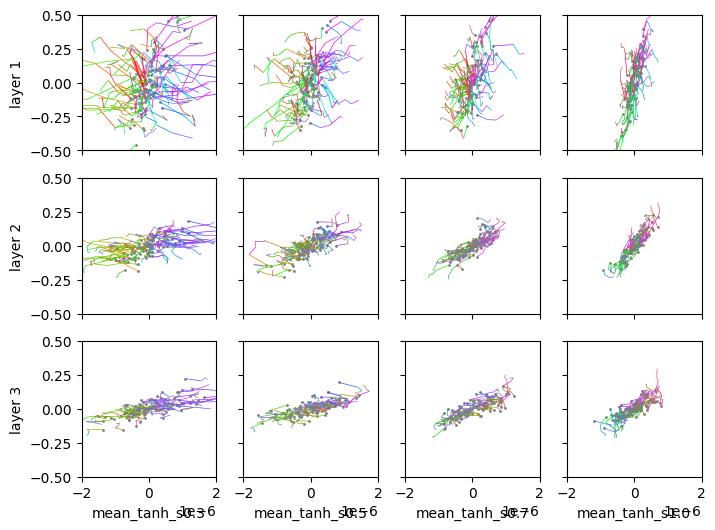

In [55]:
num_epochs = 5
num_steps = 100
n = 1000 // num_steps
_, axes = gridplot(labels, layers)
for j, label in enumerate(labels):
    s = Snapshot(dir_path, label, sample, 0, num_epochs, num_steps)()
    for i, layer in enumerate(layers):
        ax = axes[i][j]
        #kx, rx = f"{i*3+4}.weight.t1", (-.5, .5)
        kx, rx = f"{i*3+3}.grad.m2", (-2e-6, 2e-6)
        ky, ry = f"{i*3+3}.state.m2", (-.5, .5)
        xs = [t[kx][idx] for t in s]
        ys = [t[ky][idx] for t in s]
        xs = [torch.stack(xs[e*n:][:n]).mean(0) for e in range(num_epochs)]
        ys = [torch.stack(ys[e*n:][:n]).mean(0) for e in range(num_epochs)]
        plot_segments(ax, xs, ys, rx, ry)

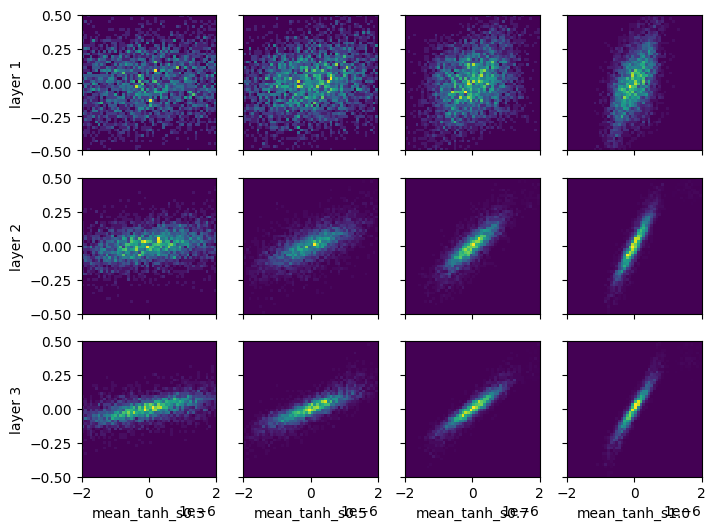

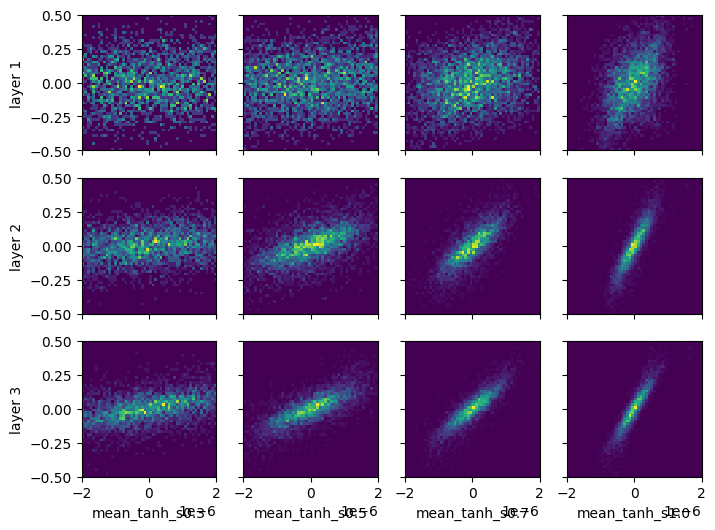

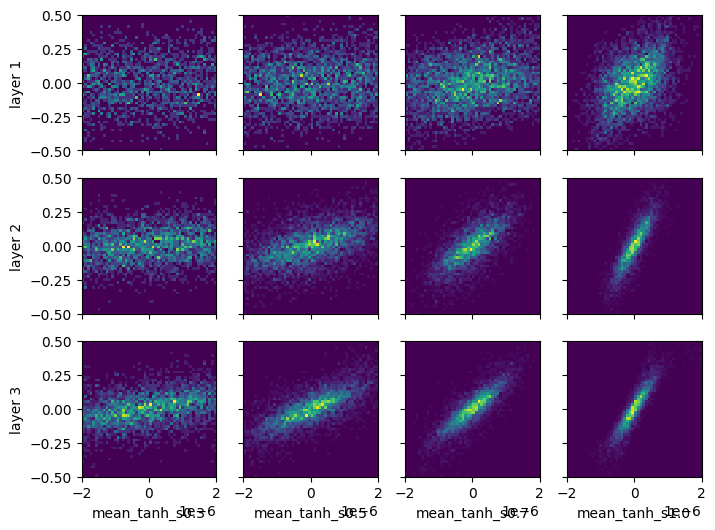

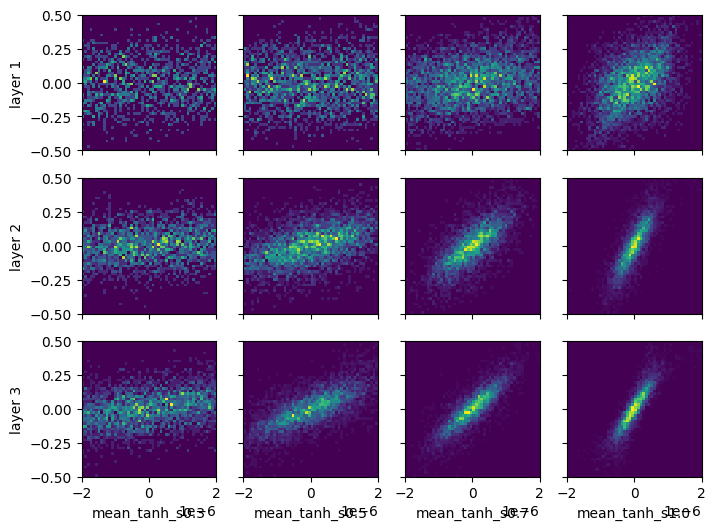

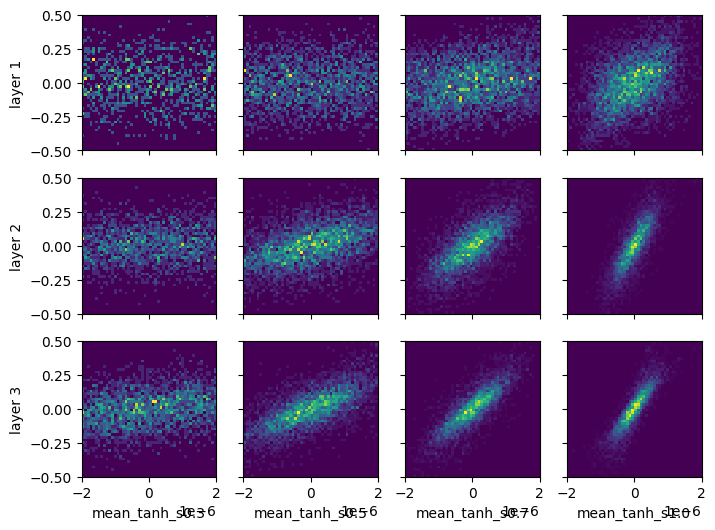

In [67]:
num_epochs = 0
num_steps = 1000
for epoch in epochs[1:]:
    _, axes = gridplot(labels, layers)
    for j, label in enumerate(labels):
        s = Snapshot(dir_path, label, sample, epoch, epoch, num_steps)()
        for i, layer in enumerate(layers):
            ax = axes[i][j]
            #kx, rx = f"{i*3+4}.weight.t1", (-.5, .5)
            kx, rx = f"{i*3+3}.grad.m2", (-2e-6, 2e-6)
            ky, ry = f"{i*3+3}.state.m2", (-.5, .5)
            x = s[0][kx]
            y = s[0][ky]
            x = x.flatten().numpy()
            y = y.flatten().numpy()
            ax.hist2d(x, y, bins=(50, 50), range=(rx, ry))

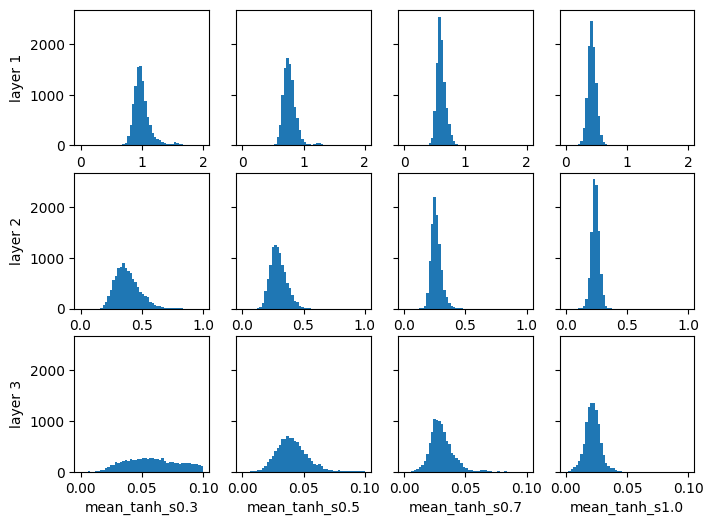

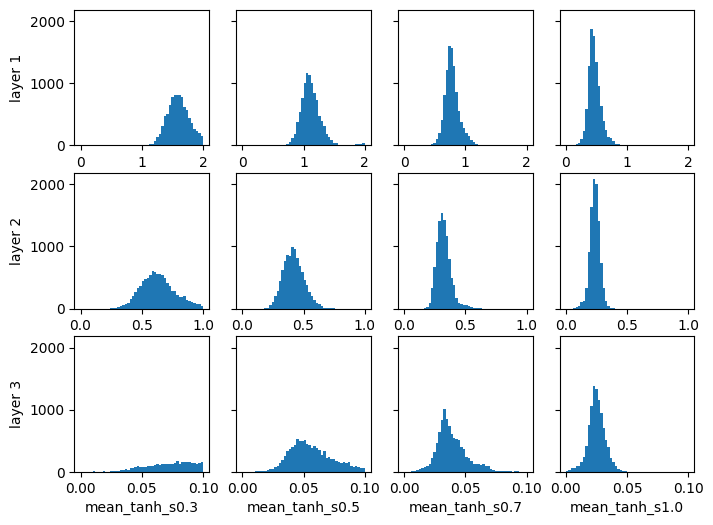

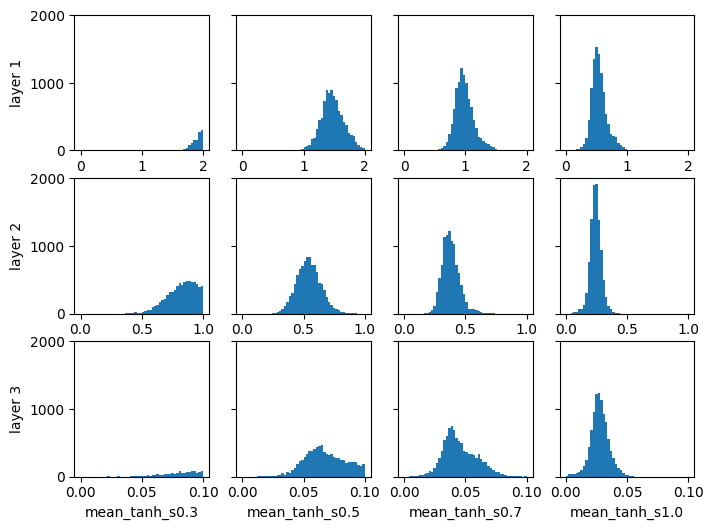

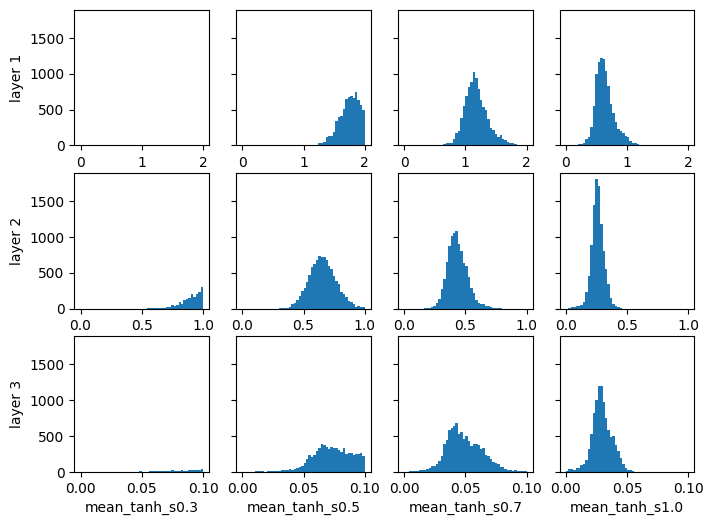

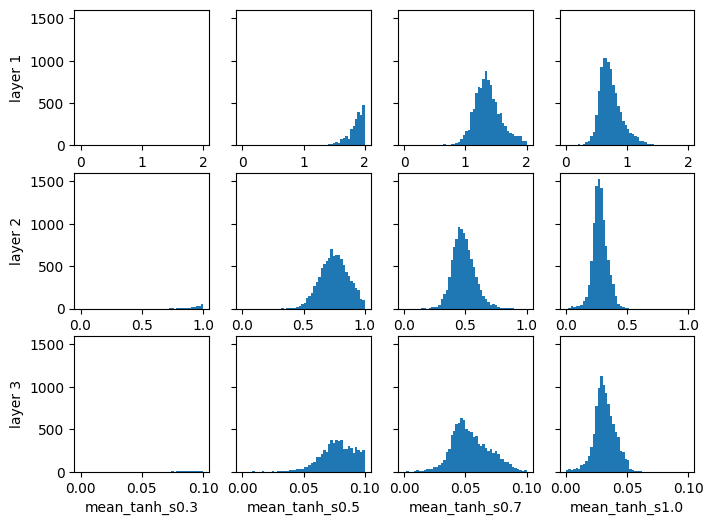

In [80]:
num_epochs = 0
num_steps = 1000
ranges = [(0, 2), (0, 1), (0, 0.1)]
for epoch in epochs[1:]:
    _, axes = gridplot(labels, layers, sharex=False)
    for j, label in enumerate(labels):
        s = Snapshot(dir_path, label, sample, epoch, epoch, num_steps)()
        for i, layer in enumerate(layers):
            ax = axes[i][j]
            kx, rx = f"{i*3+4}.weight.t1", (-.5, .5)
            #kx, rx = f"{i*3+3}.grad.m2", (-2e-6, 2e-6)
            ky, ry = f"{i*3+3}.state.m2", (-.5, .5)
            x = s[0][kx]
            y = s[0][ky]
            z = diff2(x * y)
            z.fill_diagonal_(torch.nan)
            z = z.flatten().numpy()
            ax.hist(z, bins=50, range=ranges[i])